## This is the project made into a jupyter notebook for ease of running certain parts without having to run the whole program again

In [2]:
!pip install numpy==1.24.3
!pip install gensim

  Using cached numpy-1.24.3.tar.gz (10.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\Mei\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
      main()
    File "C:\Users\Mei\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
      json_out["return_val"] = hook(**hook_input["kwargs"])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\Mei\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 137, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\Mei\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Read the dataset
df = pd.read_csv("anime-dataset.csv")

# Drop the unnecessary fields, like the ID of the anime
df = df.drop(['anime_id', 'Producers', 'Licensors', 'Studios'], axis=1)

### A general overview of our initial dataset

In [5]:
# Give a general overview of the dataset
print(df.head())
print(df.describe())
print(df.info())

   Score                             Name             English name  \
0   8.78                     Cowboy Bebop             Cowboy Bebop   
1   8.39  Cowboy Bebop: Tengoku no Tobira  Cowboy Bebop: The Movie   
2   8.24                           Trigun                   Trigun   
3   7.27               Witch Hunter Robin       Witch Hunter Robin   
4   6.98                   Bouken Ou Beet   Beet the Vandel Buster   

                                            Synopsis  \
0  Crime is timeless. By the year 2071, humanity ...   
1  Another day, another bounty—such is the life o...   
2  Vash the Stampede is the man with a $$60,000,0...   
3  Robin Sena is a powerful craft user drafted in...   
4  It is the dark century and the people are suff...   

                                              Genres   Type Episodes  \
0    Action, Adventure, Comedy, Drama, Sci-Fi, Space     TV       26   
1              Action, Drama, Mystery, Sci-Fi, Space  Movie        1   
2  Action, Sci-Fi, Adventu

 ### Plot the distribution of scores

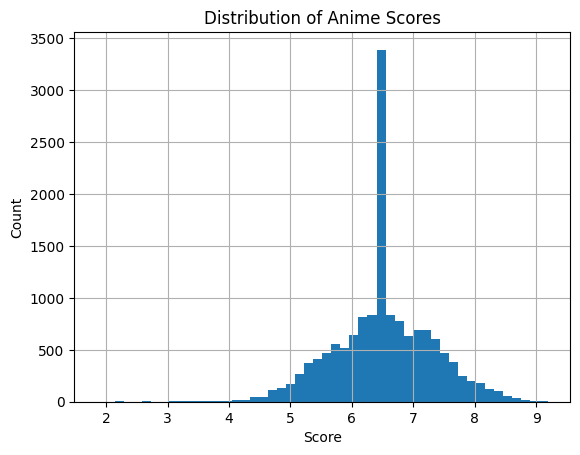

In [6]:
# Plot the score distribution
df['Score'].hist(bins=50)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Anime Scores')
plt.show()

### Process the title and synopsis using word embeddings and Doc2Vec.

In [7]:
def score_to_tag(score):
    if 9 <= score <= 10:
        return "amazing"
    elif 7 <= score < 9:
        return "good"
    elif 5 <= score < 7:
        return "okay"
    elif 3 <= score < 5:
        return "bad"
    else:
        return "terrible"

# Check if an english name is available if not then replace it with the japanese name
df['English name'] = df['English name'].where(
    ~df['English name'].str.strip().isin(['', 'UNKNOWN', np.nan]),
    df['Name']
)
# Replace the empty description with an empty string
df['Synopsis'] = df['Synopsis'].replace(["No description available for this anime.", np.nan], "")

# Use word embeddings on the title and synopsis
tagged_titles = [
    TaggedDocument(words=word_tokenize(title.lower()), tags=[f"TITLE_{i}", score_to_tag(score)])
    for i, (title, score) in enumerate(zip(df['English name'], df['Score']))
]

tagged_synopses = [
    TaggedDocument(words=word_tokenize(synopsis.lower()), tags=[f"SYNOPSIS_{i}", score_to_tag(score)])
    for i, (synopsis, score) in enumerate(zip(df['Synopsis'], df['Score']))
]

# Train the models for the title and synopsis using Doc2Vec
title_model = Doc2Vec(vector_size=50, window=2, min_count=1, epochs=40, dm=1, workers=4)
title_model.build_vocab(tagged_titles)
title_model.train(tagged_titles, total_examples=title_model.corpus_count, epochs=title_model.epochs)

synopsis_model = Doc2Vec(vector_size=100, window=5, min_count=2, epochs=40, dm=1, workers=4)
synopsis_model.build_vocab(tagged_synopses)
synopsis_model.train(tagged_synopses, total_examples=synopsis_model.corpus_count, epochs=synopsis_model.epochs)

# Retrieve the vectors for the title and synopsis
title_vectors = np.vstack([
    title_model.dv[f"TITLE_{i}"] for i in range(len(df))
])

synopsis_vectors = np.vstack([
    synopsis_model.dv[f"SYNOPSIS_{i}"] for i in range(len(df))
])

# Turn the vectors into dataframes then add them to the dataframe and then drop the old columns
title_df = pd.DataFrame(title_vectors, columns=[f"title_vec_{i}" for i in range(title_vectors.shape[1])])
synopsis_df = pd.DataFrame(synopsis_vectors, columns=[f"synopsis_vec_{i}" for i in range(synopsis_vectors.shape[1])])

df_vectors = pd.concat([df.reset_index(drop=True), title_df, synopsis_df], axis=1)
df = df_vectors.drop(['Name', 'English name', 'Synopsis'], axis=1)

### Process the genres by using one-hot encoding

In [8]:
# Split genres by commas
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['Genres'].str.split(', '))
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

# Add to dataframe
df = pd.concat([df, genre_df], axis=1)
df = df.drop(['Genres'], axis=1)

### Process aired by turning it into how many days it aired for

In [9]:
# Trying to turn the dates into a datetime
def parse_date(date_str):
    date_str = date_str.strip()

    # Checks if it's just a year
    if re.fullmatch(r'\d{4}', date_str):
        return datetime(int(date_str), 1, 1)

    # The other possible formats for the dates which are something like dd-mon-yy or mon dd, yyyy
    date_formats = ['%d-%b-%y', '%b %d, %Y']

    for fmt in date_formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue

    return None


# Calculates how many days an anime aired for
def calculate_days_aired(aired_str):
    # Checks to if there's any info on it first
    if pd.isnull(aired_str) or aired_str.strip().lower() == 'unknown':
        return np.nan

    # Takes into account the 'to' in the formating
    if 'to' in aired_str:
        # If it has a 'to' it'll split it into a start date and an end date
        start_str, end_str = aired_str.split('to')
        start_date = parse_date(start_str)
        end_str = end_str.strip()

        # If the end date is ? or nothing that means it's still airing so set the date to today otherwise turn it into a date
        if end_str == '?' or end_str == '':
            end_date = datetime.now()
        else:
            end_date = parse_date(end_str)
    # If there is no 'to' then that means it only aired once so like a movie so just make the end date the start date
    else:
        start_date = parse_date(aired_str)
        end_date = start_date

    # Now we can calculate how many days it aired for
    if start_date and end_date:
        days = (end_date - start_date).days + 1
        return days if days > 0 else 1
    # Something happened so just put the value as NaN
    else:
        return np.nan

# Changes the dates aired into how many days it aired for to make it into a value that's easier to work with
df['Aired_Days'] = df['Aired'].apply(calculate_days_aired)
df = df.drop(['Aired'], axis=1)

### Process premiered by splitting the season and year and one-hot encoding the season

In [10]:
def split_premiered(premiered_str):
    if premiered_str.lower() == 'unknown':
        return np.nan, np.nan

    parts = premiered_str.split(' ')
    season = parts[0]

    try:
        year = int(parts[1])
    except (IndexError, ValueError):
        year = np.nan

    return season, year


df[['Season', 'Year']] = df['Premiered'].apply(lambda x: pd.Series(split_premiered(x)))
df = df.drop(['Premiered'], axis=1)

### Process the duration by turning it into minutes

In [11]:
# Function to convert duration string to total seconds
def parse_duration(duration_str):
    if pd.isnull(duration_str):
        return np.nan

    # Search for numbers before 'hr.', 'min.', and 'sec.'
    hours = re.search(r'(\d+)\s*hr', duration_str)
    minutes = re.search(r'(\d+)\s*min', duration_str)
    seconds = re.search(r'(\d+)\s*sec', duration_str)

    total_seconds = 0
    if hours:
        total_seconds += int(hours.group(1)) * 3600  # 1 hr = 3600 sec
    if minutes:
        total_seconds += int(minutes.group(1)) * 60  # 1 min = 60 sec
    if seconds:
        total_seconds += int(seconds.group(1))  # seconds

    return total_seconds / 60 if total_seconds > 0 else np.nan  # Ensure NaN if no time found


# Apply the function
df['Duration_Minutes'] = df['Duration'].apply(parse_duration)
df = df.drop(['Duration'], axis=1)

### Process episodes by turning it into a float

In [12]:
df['Episodes'] = df['Episodes'].replace('Unknown', np.nan)
df['Episodes'] = pd.to_numeric(df['Episodes'], errors='coerce')

### Process the, type, season, source, rating, and status by one-hot encoding them

In [13]:
categorical_cols = ['Type', 'Season', 'Source', 'Rating', 'Status']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')
df = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, dummy_na=False)
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

### Prepare everything to start training the models

In [14]:
from sklearn.ensemble import BaggingRegressor

df = df.fillna(df.median(numeric_only=True))

X = df.drop('Score', axis=1)
y = df['Score']

# Help standardize the features and normalize the score
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
score_scaler = MinMaxScaler()
y_scaled = score_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# Attempt to use bagging
bagging = BaggingRegressor(estimator=SGDRegressor(max_iter=1000, tol=1e-3), n_estimators=20, random_state=42)
bagging.fit(X_scaled, y)
coefs = np.array([est.coef_ for est in bagging.estimators_])
avg_coefs = np.mean(np.abs(coefs), axis=0)

# Find the importance of each feature to see which ones are the best
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': avg_coefs})
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(200)['feature'].tolist()
X_top = X[top_features]

X_top_scaled = scaler.fit_transform(X_top)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

### Logistic Regression implementation utilizing bagging to account for the most important features only

In [15]:
# Train the linear regression model then calculate the RMSE
final_model = SGDRegressor(max_iter=1000, tol=1e-3)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE: {rmse:.2f}")

RMSE: 0.07


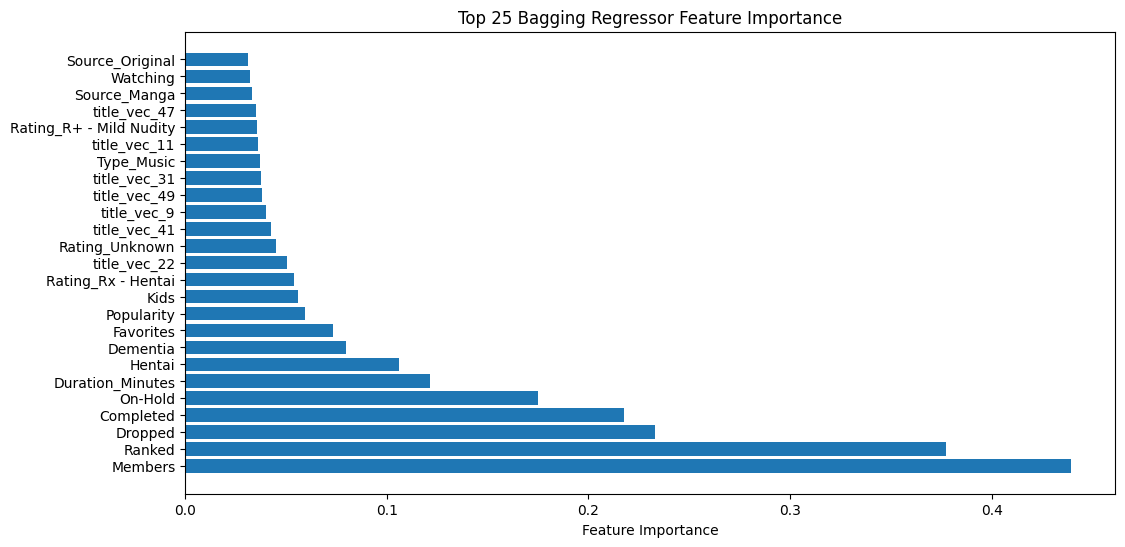

In [16]:
# --- Number of top important features to display ---
top_n = 25

# --- Get the top N important features by sorting them based on importance ---
sorted_idx = np.argsort(avg_coefs)[::-1]  # Sort in descending order
top_idx = sorted_idx[:top_n]

# --- Get the names and importance values of the top N important features ---
top_features_bagging = X.columns[top_idx]
top_importance_values_bagging = avg_coefs[top_idx]

# --- Plot the top N feature importance ---
plt.figure(figsize=(12, 6))
plt.barh(top_features_bagging, top_importance_values_bagging)
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Bagging Regressor Feature Importance')
plt.show()


                     feature  importance
1                     Ranked    0.050516
8                    Dropped    0.031978
3                    Members    0.029639
7                    On-Hold    0.025824
205         Duration_Minutes    0.016919
170                   Hentai    0.009945
2                 Popularity    0.009203
163                 Dementia    0.008913
174                     Kids    0.008620
20              title_vec_11    0.007831
4                  Favorites    0.007828
238  Rating_R+ - Mild Nudity    0.007253
240           Rating_Unknown    0.007211
227          Source_Original    0.005893
172                   Horror    0.005643
50              title_vec_41    0.005433
166                    Ecchi    0.005114
31              title_vec_22    0.005034
18               title_vec_9    0.004652
207               Type_Music    0.004540


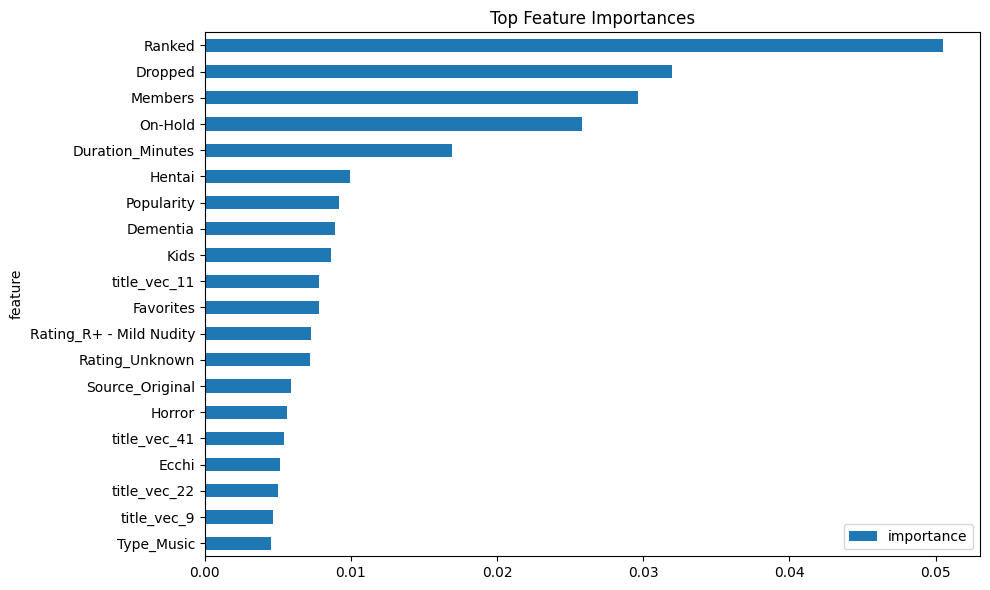

In [17]:
# Get absolute values of the coefficients for importance
coefs = np.abs(final_model.coef_)

# Create a DataFrame to map features to their importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': coefs
}).sort_values(by='importance', ascending=False)

# Print top 20 important features
print(importance_df.head(20))

# Plot top 20
importance_df.head(20).plot(kind='barh', x='feature', y='importance', title='Top Feature Importances', figsize=(10, 6))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest RMSE: {rmse_rf:.2f}")


Random Forest RMSE: 0.01


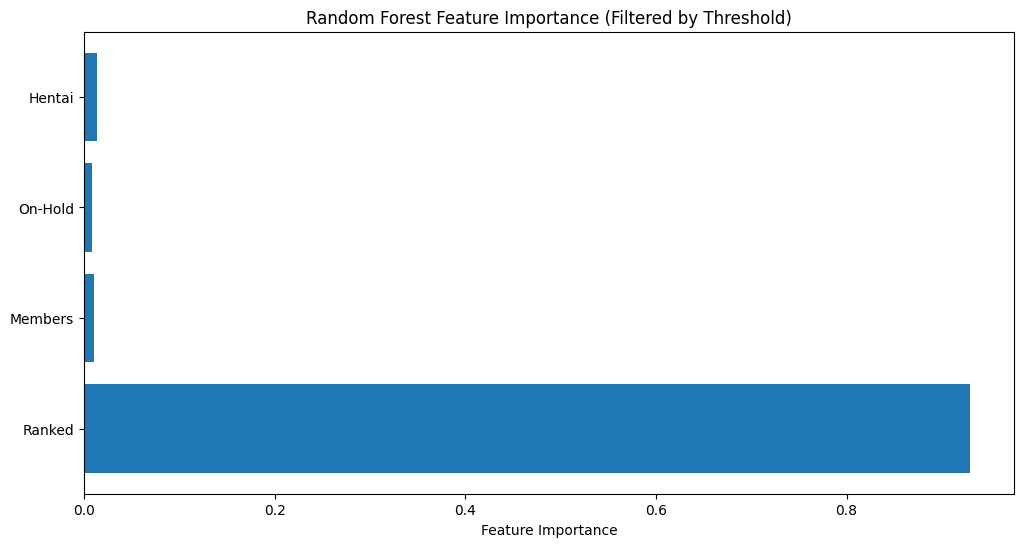

In [19]:
# --- Extract feature importance from the trained Random Forest model ---
rf_feature_importance = rf_model.feature_importances_

# --- Set a threshold for feature importance (e.g., keep features with importance > 0.01) ---
importance_threshold = 0.005

# --- Get the important features (boolean mask for importance > threshold) ---
important_rf_features = rf_feature_importance > importance_threshold

# --- Get the names of the important features ---
X_important_rf = X.columns[important_rf_features]

# --- Get the importance values of the important features ---
importance_values = rf_feature_importance[important_rf_features]

# --- Plot the feature importance for the important features ---
plt.figure(figsize=(12, 6))
plt.barh(X_important_rf, importance_values)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Filtered by Threshold)')
plt.show()

In [28]:
from xgboost import XGBRegressor

# Train the model
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split as DataFrames
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_scaled, test_size=0.2, random_state=42)

# Fit XGBoost with named features
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"XGBoost RMSE: {rmse:.4f}")

XGBoost RMSE: 0.0721


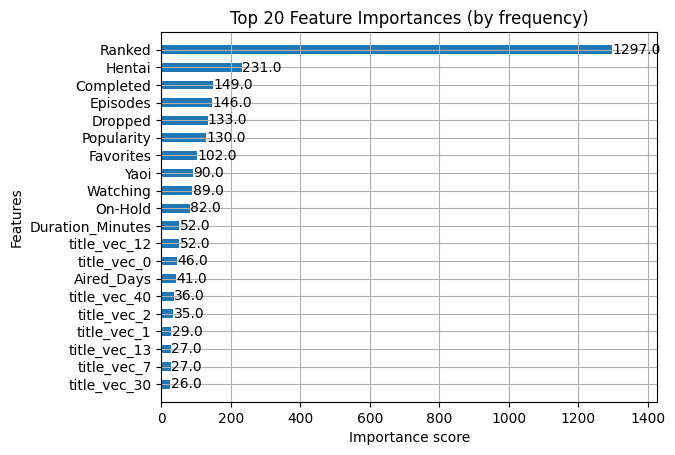

In [29]:
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=20, importance_type='weight', height=0.5)
plt.title("Top 20 Feature Importances (by frequency)")
plt.show()

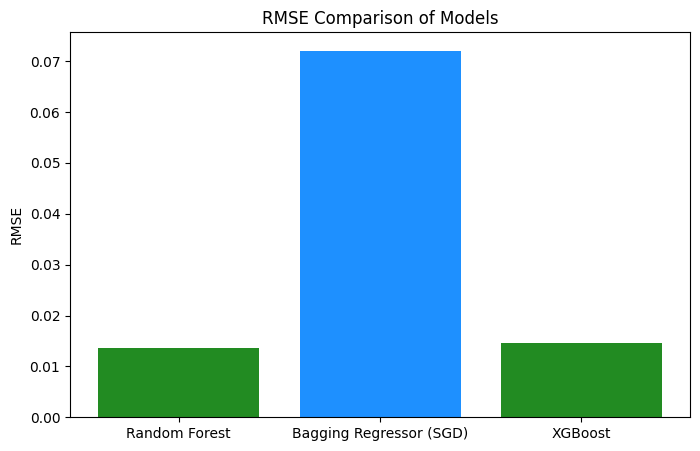

In [30]:
# RMSE values
models = ['Random Forest', 'Bagging Regressor (SGD)', 'XGBoost']
rmse_values = [rmse_rf, rmse, rmse_xgb]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values, color=['forestgreen', 'dodgerblue'])
plt.ylabel('RMSE')
plt.title('RMSE Comparison of Models')
plt.show()